In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import model
from dataset import PathDataset, RandomCutDataset ## cropped dataset
from utils import gen_bcelg2list, gen_bcelg2control, gen_bcelg2lists_ctrls, bcelosswithlog2

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

hidden_channels_list = [16, 32, 64, 128, 256]
scale_list           = [(2, 1, 1)]
nblocks              = 2
s_nblocks            = 2
activation           = nn.ReLU()
dropout              = 0.5
partial              = (64, 192) ########################
JNet = model.JNet(hidden_channels_list  = hidden_channels_list ,
                  nblocks               = nblocks              ,
                  s_nblocks             = s_nblocks            ,
                  activation            = activation           ,
                  dropout               = dropout              ,
                  scale_list            = scale_list           ,
                  mu_z                  = 0.2                  ,
                  sig_z                 = 0.2                  ,
                  bet_xy                = 6.                   ,
                  bet_z                 = 35.                  ,
                  superres              = False                ,
                  )
JNet = JNet.to(device = device)
scale = 1
val_dataset   = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                 imagename   =  '_x1'            ,
                                 labelname   =  '_label'         ,
                                 size        =  (768, 768, 768)  ,
                                 cropsize    =  (128, 128, 128)  ,
                                 I           =  200              ,
                                 low         =   16              ,
                                 high        =   20              ,
                                 scale       =    1              ,
                                 train       = False             ,
                                )
val_dataset256 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (256,  64,  64)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                 )


In [3]:
model_names = ['JNet_77_x1', 'JNet_81_x1_256', 'JNet_83_x1_partial', 'JNet_86_x1_partial']
val_datasets = [val_dataset, val_dataset256, val_dataset256, val_dataset]
partials = [None, None, (64, 192), (32, 96)]

In [4]:
bcess = gen_bcelg2lists_ctrls(JNet, model_names, val_datasets, device, partials)

In [16]:
arr = np.array(bcess[3])
c   = np.array([-100])
arr = np.setdiff1d(arr, c)
bces = arr.tolist()
bcess[3] = bces

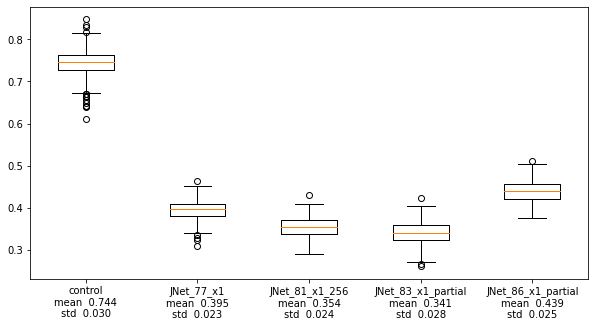

In [26]:
model_names = ['JNet_77_x1', 'JNet_81_x1_256', 'JNet_83_x1_partial', 'JNet_86_x1_partial']
model_names.insert(0, 'control')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bcess))
ax.set_xticklabels([f"{model_names[i]}\nmean  {np.mean(bcess[i]):.3f}\nstd  {np.std(bcess[i]):.3f}"for i in range(len(bcess))])
fig.show()

## Experiment 1 (`JNet_77_x1`)

In [38]:
model_name = 'JNet_77_x1'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset224 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (224, 128, 128)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                 )
J = 4
bces = [[] for _ in range(J)]
ctrls = [[] for _ in range(J)]
for i in range(len(val_dataset224)):
    image, label = val_dataset224[i]
    label = label.chunk(chunks=7, dim=1)[3]
    for j in range(J):
        simage  = image[:, j*32:j*32+128, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        bce  = bcelosswithlog2(pred, label)
        if -100 < bce < 100:
            bces[-1-j].append(bce)
        ctrl = bcelosswithlog2(torch.ones_like(label) * torch.mean(label), label)
        if -100 < ctrl < 100:
            ctrls[-1-j].append(ctrl)
ctrl = [item for ctrl in ctrls for item in ctrl]
bces.insert(0, ctrl)

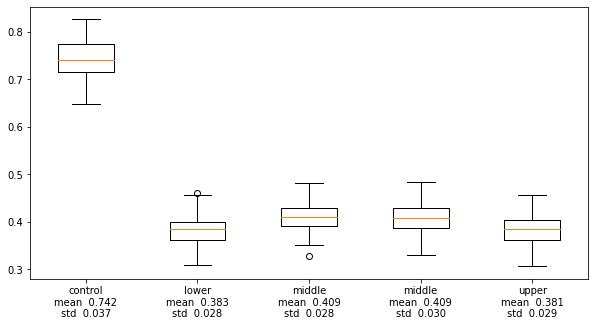

In [39]:
names = ['control', 'lower', 'middle', 'middle', 'upper']
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.3f}\nstd  {np.std(bces[i]):.3f}"for i in range(len(bces))])
fig.show()

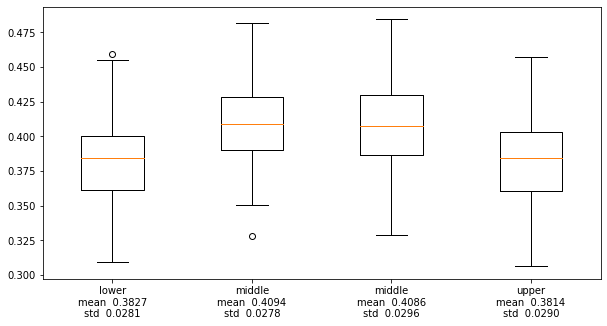

In [40]:
bces.pop(0)
names.pop(0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.4f}\nstd  {np.std(bces[i]):.4f}"for i in range(len(bces))])
fig.show()

## Experiment 2 (`JNet_81_x1_256`)

In [59]:
# experiment2
model_name = 'JNet_81_x1_256'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset480 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (480,  64,  64)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                  seed        = 905
                                 )

In [47]:
J = 4
bces = [[] for _ in range(J)]
ctrls = [[] for _ in range(J)]
for i in range(len(val_dataset480)):
    image, label = val_dataset480[i]
    label = label.chunk(chunks=15, dim=1)[7]
    for j in range(4):
        simage  = image[:, j*32+64:j*32+320, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred    = pred[:, 64:192, :, :]
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        bce  = bcelosswithlog2(pred, label)
        if -100 < bce < 100:
            bces[-1-j].append(bce)
        ctrl = bcelosswithlog2(torch.ones_like(label) * torch.mean(label), label)
        if -100 < ctrl < 100:
            ctrls[-1-j].append(ctrl)
ctrl = [item for ctrl in ctrls for item in ctrl]
bces.insert(0, ctrl)

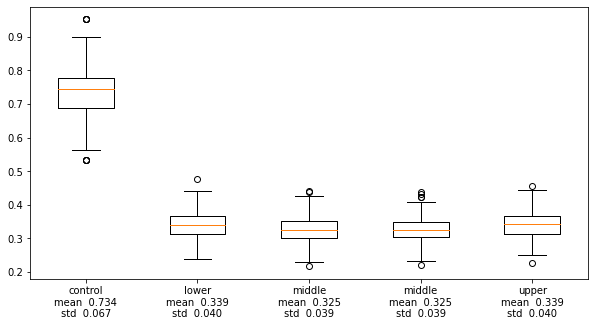

In [48]:
names = ['control', 'lower', 'middle', 'middle', 'upper']
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.3f}\nstd  {np.std(bces[i]):.3f}"for i in range(len(bces))])
fig.show()

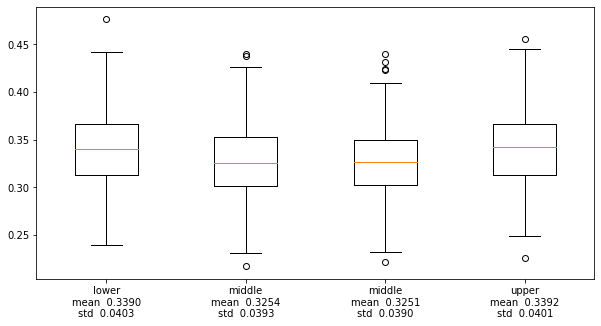

In [49]:
bces.pop(0)
names.pop(0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.4f}\nstd  {np.std(bces[i]):.4f}"for i in range(len(bces))])
fig.show()

In [60]:
J = 8
bces = [[] for _ in range(J)]
ctrls = [[] for _ in range(J)]

for i in range(len(val_dataset480)):
    image, label = val_dataset480[i]
    label = label.chunk(chunks=15, dim=1)[7]
    for j in range(8):
        simage  = image[:, j*32:j*32+256, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred = pred[:, (7-j)*32:(8-j)*32, :, :].detach()
        bce  = bcelosswithlog2(pred, label)
        if -100 < bce < 100:
            bces[-1-j].append(bce)
        ctrl = bcelosswithlog2(torch.ones_like(label) * torch.mean(label), label)
        if -100 < ctrl < 100:
            ctrls[-1-j].append(ctrl)
ctrl = [item for ctrl in ctrls for item in ctrl]
bces.insert(0, ctrl)

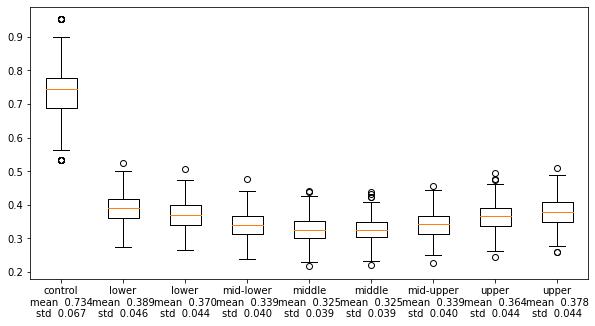

In [61]:
names = ['control',
         'lower'  ,
         'lower'  ,
         'mid-lower',
         'middle' ,
         'middle' ,
         'mid-upper',
         'upper'  ,
         'upper'  ,]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.3f}\nstd  {np.std(bces[i]):.3f}"for i in range(len(bces))])
fig.show()

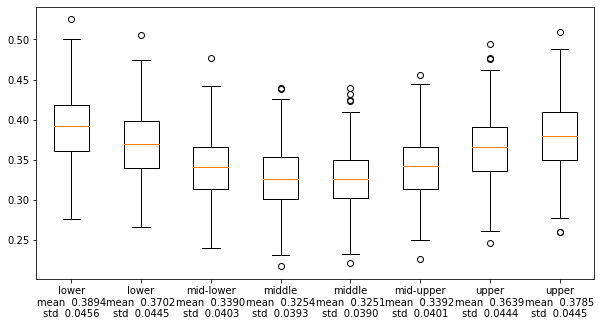

In [62]:
bces.pop(0)
names.pop(0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.4f}\nstd  {np.std(bces[i]):.4f}"for i in range(len(bces))])
fig.show()

## Experiment 3 (`JNet_83_x1_partial`)

In [63]:
model_name = 'JNet_83_x1_partial'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset480 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (480,  64,  64)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                  seed        = 905
                                 )


In [42]:
J = 4
bces = [[] for _ in range(J)]
ctrls = [[] for _ in range(J)]
for i in range(len(val_dataset480)):
    image, label = val_dataset480[i]
    label = label.chunk(chunks=15, dim=1)[7]
    for j in range(J):
        simage  = image[:, j*32+64:j*32+320, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred    = pred[:, 64:192, :, :]
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        bce  = bcelosswithlog2(pred, label)
        if -100 < bce < 100:
            bces[-1-j].append(bce)
        ctrl = bcelosswithlog2(torch.ones_like(label) * torch.mean(label), label)
        if -100 < ctrl < 100:
            ctrls[-1-j].append(ctrl)
ctrl = [item for ctrl in ctrls for item in ctrl]
bces.insert(0, ctrl)

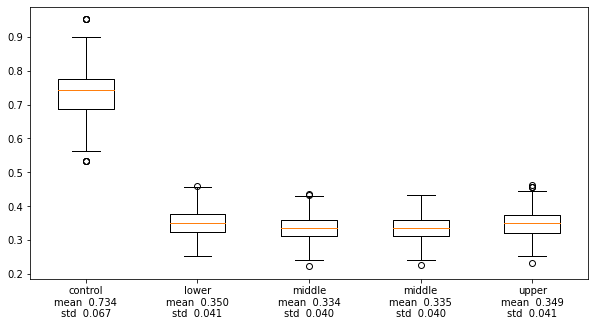

In [43]:
names = ['control', 'lower', 'middle', 'middle', 'upper']
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.3f}\nstd  {np.std(bces[i]):.3f}"for i in range(len(bces))])
fig.show()

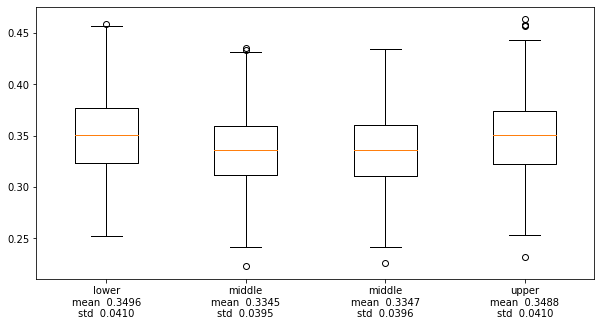

In [44]:
bces.pop(0)
names.pop(0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.4f}\nstd  {np.std(bces[i]):.4f}"for i in range(len(bces))])
fig.show()

In [64]:
J = 8
bces = [[] for _ in range(J)]
ctrls = [[] for _ in range(J)]

for i in range(len(val_dataset480)):
    image, label = val_dataset480[i]
    label = label.chunk(chunks=15, dim=1)[7]
    for j in range(8):
        simage  = image[:, j*32:j*32+256, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred = pred[:, (7-j)*32:(8-j)*32, :, :].detach()
        bce  = bcelosswithlog2(pred, label)
        if -100 < bce < 100:
            bces[-1-j].append(bce)
        ctrl = bcelosswithlog2(torch.ones_like(label) * torch.mean(label), label)
        if -100 < ctrl < 100:
            ctrls[-1-j].append(ctrl)
ctrl = [item for ctrl in ctrls for item in ctrl]
bces.insert(0, ctrl)

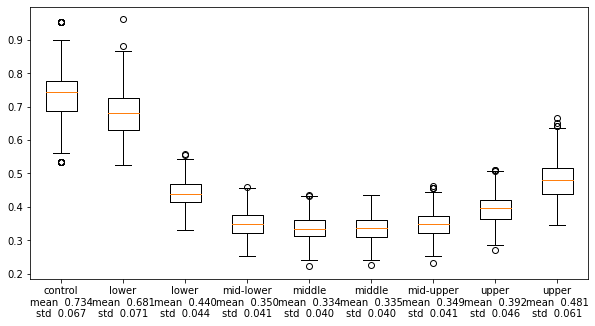

In [65]:
names = ['control',
         'lower'  ,
         'lower'  ,
         'mid-lower',
         'middle' ,
         'middle' ,
         'mid-upper',
         'upper'  ,
         'upper'  ,]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.3f}\nstd  {np.std(bces[i]):.3f}"for i in range(len(bces))])
fig.show()

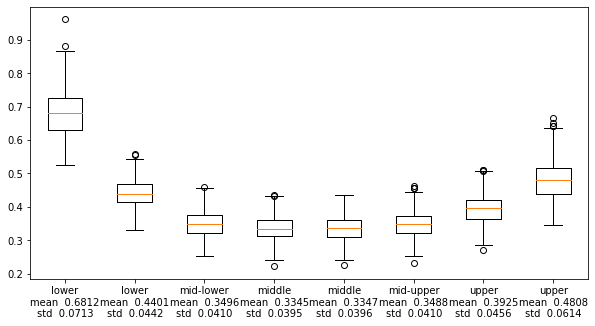

In [66]:
bces.pop(0)
names.pop(0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.4f}\nstd  {np.std(bces[i]):.4f}"for i in range(len(bces))])
fig.show()

## Experiment 4 (`JNet_86_x1_partial`)

In [124]:
model_name = 'JNet_86_x1_partial'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset224 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (224, 128, 128)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                  seed        = 905
                                 )

In [125]:
J = 4
bces = [[] for _ in range(J)]
ctrls = [[] for _ in range(J)]
for i in range(len(val_dataset224)):
    image, label = val_dataset224[i]
    label = label.chunk(chunks=7, dim=1)[3]
    for j in range(J):
        simage  = image[:, j*32:j*32+128, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        bce  = bcelosswithlog2(pred, label)
        if -100 < bce < 100:
            bces[-1-j].append(bce)
        ctrl = bcelosswithlog2(torch.ones_like(label) * torch.mean(label), label)
        if -100 < ctrl < 100:
            ctrls[-1-j].append(ctrl)
ctrl = [item for ctrl in ctrls for item in ctrl]
bces.insert(0, ctrl)

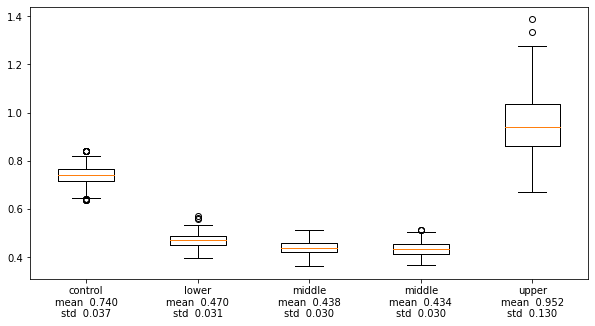

In [126]:
names = ['control', 'lower', 'middle', 'middle', 'upper']
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.3f}\nstd  {np.std(bces[i]):.3f}"for i in range(len(bces))])
fig.show()

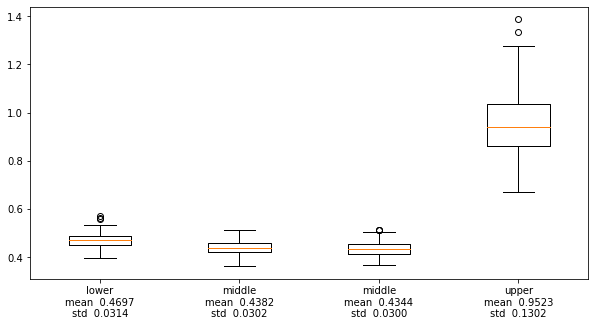

In [127]:
bces.pop(0)
names.pop(0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((bces))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(bces[i]):.4f}\nstd  {np.std(bces[i]):.4f}"for i in range(len(bces))])
fig.show()

In [150]:
perps = []
for bce in bces:
    arr = np.array(bce)
    perp = 2. ** arr
    perp = perp.tolist()
    perps.append(perp)

In [151]:
len(perps)

4

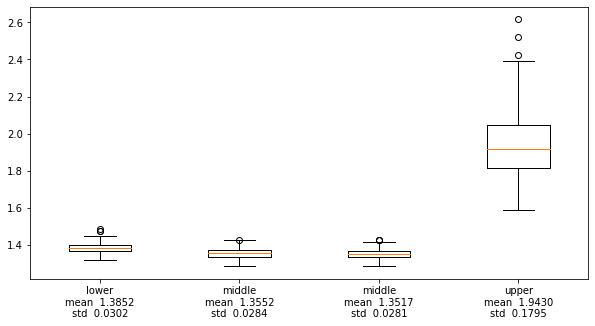

In [152]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.boxplot((perps))
ax.set_xticklabels([f"{names[i]}\nmean  {np.mean(perps[i]):.4f}\nstd  {np.std(perps[i]):.4f}"for i in range(len(perps))])
fig.show()